In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling2D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import wave
import struct
import IPython.display as ipd  # To play sound in the notebook
import python_speech_features as ps
import seaborn as sns
import scipy

import pyaudio
import math
import datetime
from concurrent.futures.process import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import threading
import time
from multiprocessing import Process

In [222]:
class emotionAnalizer():
    def __init__(self):
        super().__init__()
        self.alive = True
        self.extractMellalive = False
        #inputAudioに必要な初期化
        self.CHUNK=1024
        self.RATE = 44100
        self.wave = np.empty((0,1024),int)
        self.audio = pyaudio.PyAudio()
        self.stream=self.audio.open(format = pyaudio.paInt16,
            channels = 1,
            rate = self.RATE,
            frames_per_buffer = self.CHUNK,
            input = True,
            output=True)
        #detectAudioに必要な初期化
        self.spaceleng = 10
        self.voiceleng = 10
        self.sokuonleng = 3
        self.winlen = 0.08
        self.winstep = 0.016
        self.nfilt = 40 #周波数の分解能
        self.waddr = 0
        self.ave = np.empty((1,), float) #diffで過去のデータを参照するなので1つ余分に作っておく。
        self.diff = np.empty((0,), float)
        self.silent = 0
        self.voice  = 0
        self.standby = -1
        self.isVoice = 0
        self.voiceOnWave = np.empty((0,2,2), int)
        #extractMellに必要な初期化
        self.pastVoiceOnWaveLeng = 0
        self.init = 0
        self.lastwaddr = 0
        self.features = np.zeros((0, 300, self.nfilt, 3))
        self.eps = 1e-5
        with open('mean_and_std.pkl', 'rb') as file:
          self.mean1,self.std1,self.mean2,self.std2,self.mean3,self.std3 = pickle.load(file)
        #emotionRecognitionに必要な初期化
        self.faddr = 0
        self.emotionResult = np.zeros((0,14))
        # loading json and model architecture 
        json_file = open('model_json.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.loaded_model = model_from_json(loaded_model_json)

        # load weights into new model
        self.loaded_model.load_weights("saved_models/Emotion_Model.h5")
        print("Loaded model from disk")

    def inputAudio(self):
        while self.alive:
            #time.sleep(0.001)
            ret = self.stream.read(self.CHUNK, exception_on_overflow = False)
            #self.stream.write(ret)
            self.wave = np.append(self.wave, np.expand_dims(np.frombuffer(ret, dtype="int16"), 0), axis=0)
            #print(self.wave[-1])
    def detectVoice(self):
        if self.wave.shape[0]>0 and self.wave.shape[0] > self.waddr:
            #print("detectVoice start")
            self.ave = np.append(self.ave, np.mean(np.abs(self.wave[self.waddr])))
            self.diff = np.append(self.diff, self.ave[-2]-self.ave[-1])
            #声の部分か判定する。
            #print(np.abs(self.diff[self.waddr]))
            if np.abs(self.diff[self.waddr]) > 100:
                self.silent = 0
                self.voice  = self.sokuonleng
            else:
                self.silent += 1
                self.voice  -= 1 if self.voice > 0 else 0
            #発話していないなら
            if self.isVoice == 0:
                if self.standby == -1:
                    #スタンバイでない時、音を検知したら、スタンバイする(その時の時間を覚えておく)。
                    if self.voice == self.sokuonleng:
                        self.standby = self.waddr - 1 #発声する瞬間も大事な特微量なので、現在のアドレスより1コマ過去のものから判定開始
                else:
                    if self.waddr-self.standby >= self.voiceleng:
                        #voiceleng以上発話していれば、isRecをアクティブに。
                        if self.voice != 0:
                            print("Record start{}".format(self.standby, self.waddr))
                            self.isVoice = 1
                            self.voiceOnWave = np.append(self.voiceOnWave, np.zeros((1,2,2), int),0)
                            self.voiceOnWave[-1,0,0] = self.standby
                        #voicelengより短い発話だったら、スタンバイ解除
                        elif self.voice == 0:
                            self.standby = -1
            #発話しているなら
            else:
                #もしも、一定時間以上静寂なら、isRecをディスアクティブに。
                if self.silent > self.spaceleng or self.alive == False:
                    #print("--->{}".format(self.waddr-self.spaceleng, self.waddr))
                    self.isVoice = 0
                    self.standby = -1
                    self.voiceOnWave[-1,1,0] = self.waddr - self.spaceleng + 3 #+3して発話後に若干余白をとる。
            self.waddr += 1
            #print("detectVoice end")
            
    def mellCepstrum(self, start, end=None):
        #Mellの特微量を生成
        if end != None:
            mel_spec = ps.logfbank(self.wave[start:end].reshape(-1), samplerate=self.RATE, winlen=self.winlen, winstep=self.winstep, nfilt=self.nfilt, nfft=int(self.winlen*self.RATE))
        else:
            mel_spec = ps.logfbank(self.wave[start].reshape(-1), samplerate=self.RATE, winlen=self.winlen, winstep=self.winstep, nfilt=self.nfilt, nfft=int(self.winlen*self.RATE))
        #deltaの特微量を生成
        delta1= ps.delta(mel_spec, 4)
        #delta-deltaの特微量を生成
        delta2 = ps.delta(delta1, 4)
        procd = np.empty((mel_spec.shape[0], self.nfilt, 3))
        procd[:,:,0] = mel_spec#(mel_spec - self.mean1)/(self.std1+self.eps) #mel_spec#
        procd[:,:,1] = delta1#(delta1 - self.mean2)/(self.std2+self.eps) #delta1#
        procd[:,:,2] = delta2#(delta2 - self.mean3)/(self.std3+self.eps) #delta2#
        return procd
    
    def mellshape(self, arrayelem=1):
        datalen=self.CHUNK/self.RATE
        shape=(datalen*arrayelem-self.winlen)/self.winstep+1 if arrayelem > 1 else 1
        return math.ceil(shape)
                
    def extractMell(self):
        #voiceOnWave上に新しい声が登録されたら
        if self.voiceOnWave.shape[0] > self.pastVoiceOnWaveLeng:
            #isVoiceがアクティブになった直後なら
            if self.init == 0 and self.alive == True: 
                #print("init.")
                self.lastwaddr = self.voiceOnWave[-1,0,0]
                self.voiceOnWave[-1,0,1] = self.features.shape[0]
                self.extractMellalive = True
                self.init = 1
            #メル周波数ケプストラムの変換後のフレームが300フレーム以上になったら
            if self.mellshape(self.waddr-self.lastwaddr) >= 300 and self.alive == True:
                tmp = self.mellCepstrum(self.lastwaddr, self.waddr)
                self.features = np.append(self.features, np.zeros((1, 300, self.nfilt, 3)),0) 
                self.features[-1] = tmp[0:300]
                self.lastwaddr = self.waddr
                #print("Saved mell.")
            #isVoiceがディアクティブになったら(レコーディングが終了したら)
            elif self.voiceOnWave[-1,1,0] > 0 or self.alive == False:
                #type1 この処理をした時だけ、必ずAngryとHappyが下がり、Sadが急上昇する。
                #tmp = self.mellCepstrum(self.lastwaddr, self.waddr)
                #self.features = np.append(self.features, np.zeros((1, 300, self.nfilt, 3)),0)
                #self.features[-1,:-tmp.shape[0]] = self.features[-2,tmp.shape[0]:]
                #self.features[-1,-tmp.shape[0]:] = tmp
                #type2 この処理をした時だけ、必ずAngryとHappyが下がり、Sadが急上昇する。
                tmp = self.mellCepstrum(self.lastwaddr, self.waddr)
                self.features = np.append(self.features, np.zeros((1, 300, self.nfilt, 3)),0)
                self.features[-1,:tmp.shape[0]] = tmp
                #type3 この処理をした時だけ、必ずAngryとHappyが下がり、Sadが急上昇する。
                #tmp = self.mellCepstrum(self.waddr-76, self.waddr)
                #self.features = np.append(self.features, np.zeros((1, 300, self.nfilt, 3)),0)
                #self.features[-1,:tmp.shape[0]] = tmp
                self.voiceOnWave[-1,1,1] = self.features.shape[0]
                self.pastVoiceOnWaveLeng = self.voiceOnWave.shape[0]
                self.extractMellalive = False
                self.init = 0
                #print("Saved mell(end).")
    
    def inverselabel(self, value):
        tag = {'female_angry':0, 'female_disgust':1, 'female_fear':2, 'female_happy':3,
     'female_neutral':4, 'female_sad':5, 'female_surprise':6, 'male_angry':7,
     'male_disgust':8, 'male_fear':9, 'male_happy':10, 'male_neutral':11, 'male_sad':12,
     'male_surprise':13}
        return [k for k, v in tag.items() if v == value][0]
    
    def emotionRecognition(self):
            if self.faddr < self.features.shape[0]:
                preds = self.loaded_model.predict_step(np.expand_dims(self.features[self.faddr],axis=0))
                self.emotionResult = np.append(self.emotionResult, preds, 0)
                print("{}".format(self.inverselabel(self.emotionResult[-1].argmax())))
                self.faddr +=1
                
    def emotionAnalize(self):
        while self.alive or self.extractMellalive:
            #print("T_T")
            self.detectVoice()
            self.extractMell()
            self.emotionRecognition()
        
    def terminate(self):
        self.stream.stop_stream()
        self.stream.close()
    
    def run(self):
        #while self.alive:
        #    self.inputAudio()
        with ThreadPoolExecutor(max_workers=8) as executor:
                executor.submit(self.inputAudio)
                executor.submit(self.emotionAnalize)
        self.terminate()

In [223]:
eAn = emotionAnalizer()
try:
    eAn.run()
except KeyboardInterrupt:
    eAn.alive = False
    print("Realtime emotion recognition stoped.")

Loaded model from disk
Record start119
male_fear
Realtime emotion recognition stoped.


In [224]:
print(eAn.emotionResult.shape)
emotion = np.empty((0,7))
for emoresult in eAn.emotionResult:
    maxEmo = emoresult.argmax(axis=0)
    if maxEmo < 7:
        emotion = np.append(emotion, np.expand_dims(emoresult[:7],axis=0),0)
    else:
        emotion = np.append(emotion, np.expand_dims(emoresult[7:],axis=0),0)

(1, 14)


In [225]:
#print(eAn.voiceOnWave)
time_axis = np.empty(0,int)
for elem in eAn.voiceOnWave:
    for num in range(elem[1,1]-elem[0,1]):
        time_axis = np.append(time_axis, elem[0,0]+(num*76))
    if elem[1,1]-elem[0,1] > 0:
        time_axis[-1]=elem[1,0]

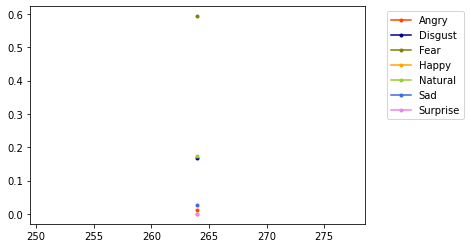

In [226]:
legend_list = ["Angry", "Disgust", "Fear", "Happy", "Natural", "Sad", "Surprise"]
linecolor = ["orangered", "navy", "olive", "orange", "yellowgreen", "royalblue", "violet"]
for start, end in  zip(eAn.voiceOnWave[:,0,1],eAn.voiceOnWave[:,1,1]):
    for i, name in zip(range(len(legend_list)),legend_list):
        plt.plot(time_axis[start:end], emotion[start:end,i], label=name,marker='.', color=linecolor[i])
    legend_list = ["", "", "", "", "", "", ""]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### 保存用コマンド

In [227]:
dt_now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
os.makedirs("output", exist_ok=True)
os.makedirs("output/"+str(dt_now), exist_ok=True)

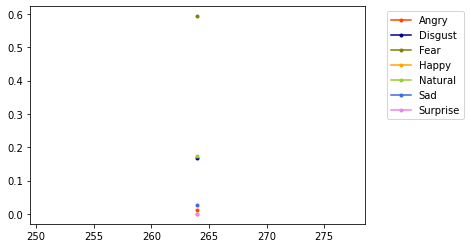

In [228]:
legend_list = ["Angry", "Disgust", "Fear", "Happy", "Natural", "Sad", "Surprise"]
linecolor = ["orangered", "navy", "olive", "orange", "yellowgreen", "royalblue", "violet"]
for start, end in  zip(eAn.voiceOnWave[:,0,1],eAn.voiceOnWave[:,1,1]):
    for i, name in zip(range(len(legend_list)),legend_list):
        plt.plot(time_axis[start:end], emotion[start:end,i], label=name,marker='.', color=linecolor[i])
    legend_list = ["", "", "", "", "", "", ""]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
filename = "output/"+str(dt_now)+"/"+"graph.png"
plt.savefig(filename)

In [229]:
for no in eAn.voiceOnWave:
    Y=eAn.wave[no[0,0]:no[1,0]].reshape(-1)
    outd = struct.pack("h" * len(Y), *Y)
    filename = "output/"+str(dt_now)+ "/trimAt" + str(no[0,0])+"-"+str(no[1,0]) + ".wav"
    # 書き出し
    with wave.open(filename, 'w') as ww:
        ww.setnchannels(1)
        ww.setsampwidth(2)
        ww.setframerate(44100)
        ww.writeframes(outd)

In [230]:
Y=eAn.wave.reshape(-1)
outd = struct.pack("h" * len(Y), *Y)
filename = "output/"+str(dt_now)+ "/All.wav"
# 書き出し
with wave.open(filename, 'w') as ww:
    ww.setnchannels(1)
    ww.setsampwidth(2)
    ww.setframerate(44100)
    ww.writeframes(outd)

### test

In [2]:
def inputAudio():
        #print("inputAudio Start")
        alive = True
        CHUNK=1024
        RATE = 44100
        wave = np.empty((0,1024),int)
        audio = pyaudio.PyAudio()
        stream=audio.open(format = pyaudio.paInt16,
                    channels = 1,
                    rate = RATE,
                    frames_per_buffer = CHUNK,
                    input = True,
                    output=True)
        while alive:
            ret = stream.read(CHUNK, exception_on_overflow = False)
            stream.write(ret)
            wave = np.append(wave, np.expand_dims(np.frombuffer(ret, dtype="int16"), 0), axis=0)

In [42]:
iA = Process(target=inputAudio)
iA.start()

Process Process-12:
Traceback (most recent call last):
  File "/Users/naokitakatani/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/naokitakatani/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-41-a45729e88fac>", line 13, in inputAudio
    output=True)
  File "/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/env/lib/python3.7/site-packages/pyaudio.py", line 750, in open
    stream = Stream(self, *args, **kwargs)
  File "/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/env/lib/python3.7/site-packages/pyaudio.py", line 441, in __init__
    self._stream = pa.open(**arguments)
OSError: [Errno -9986] Internal PortAudio error


In [3]:
emotionResult = np.zeros((0,14))
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
with open('extractMell_part.pkl', 'rb') as file:
  features, emolabel = pickle.load(file)

Loaded model from disk


In [4]:
def deqpredict():
    for index, data in enumerate(features):
        print(index)
        time.sleep(1)
        preds = loaded_model.predict_step(np.expand_dims(data,axis=0))

In [7]:
start = time.time()
dp = Process(target=deqpredict(), args=())
dp.start()
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

0
1
2
3
4


KeyboardInterrupt: 

In [5]:
def printHello():
    while True:
        print("Hello world!")
        time.sleep()

In [6]:
start = time.time()
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.submit(inputAudio)
    #executor.submit(deqpredict)
    #executor.submit(printHello)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:0.0016040802001953125[sec]


KeyboardInterrupt: 

### 実際のデータとイヤホンマイクを通したデータを比較(劣化具合を比較)

In [152]:
def loadwav(path, mono=True):
    file = wave.open(path, 'r')
    params = file.getparams()
    nchannels, samplewidth, samplerate, wav_length = params[:4]
    datatype = {2:"int16", 4:"int32"}
    str_data = file.readframes(wav_length)
    data = np.frombuffer(str_data, dtype = np.short)
    if(nchannels == 2):
        left = data[::2]
        right= data[1::2]
        wavedata = np.stack([left, right], 1)
        if mono == True:
            wavedata = np.mean(wavedata, axis=1)
            wavedata = wavedata.astype(datatype[samplewidth])
    else:
        wavedata = data
    return wavedata, samplerate, samplewidth, nchannels

In [177]:
def mellCepstrum(data, RATE, winlen=0.08, winstep=0.016, nfilt=40, start=None, end=None):
    data = np.append(data, np.zeros(1024 - data.shape[0] % 1024),0)
    eps = 1e-5
    if start == None and end == None:
        mel_spec = ps.logfbank(data, samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    elif start == None or end == None:
        point = start if end == None else end
        mel_spec = ps.logfbank(data[point], samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    else:
        mel_spec = ps.logfbank(data[start:end], samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    #deltaの特微量を生成
    delta1= ps.delta(mel_spec, 4)
    #delta-deltaの特微量を生成
    delta2 = ps.delta(delta1, 4)
    mean1 = np.mean(mel_spec,axis=0)
    mean2 = np.mean(delta1,axis=0)
    mean3 = np.mean(delta2,axis=0)
    std1 = np.std(mel_spec,axis=0)
    std2 = np.std(delta1,axis=0)
    std3 = np.std(delta2,axis=0)
    procd = np.empty((mel_spec.shape[0], nfilt, 3))
    procd[:,:,0] = mel_spec#(mel_spec - mean1)/(std1+eps) #mel_spec#
    procd[:,:,1] = delta1#(delta1 - mean2)/(std2+eps) #delta1#
    procd[:,:,2] = delta2#(delta2 - mean3)/(std3+eps) #delta2#
    return procd

In [178]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [179]:
def inverselabel(value):
    tag = {'female_angry':0, 'female_disgust':1, 'female_fear':2, 'female_happy':3,
 'female_neutral':4, 'female_sad':5, 'female_surprise':6, 'male_angry':7,
 'male_disgust':8, 'male_fear':9, 'male_happy':10, 'male_neutral':11, 'male_sad':12,
 'male_surprise':13}
    return [k for k, v in tag.items() if v == value][0]

male_fear


<AxesSubplot:>

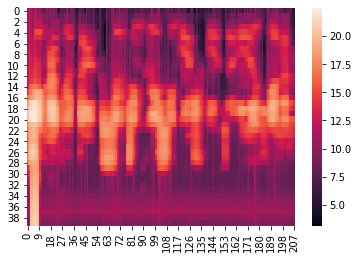

In [234]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-24-01-55-10/trimAt119-264.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
feature = np.vstack((heatmap_data, (np.zeros((300-heatmap_data.shape[0],40,3),float))))
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(heatmap_data[:,:,0].T)

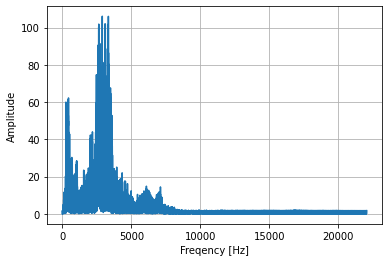

In [235]:
F = np.fft.fft(X) # 変換結果
N = X.shape[0]
freq = np.fft.fftfreq(N, d=1/44100) # 周波数
Amp = np.abs(F/(N/2)) # 振幅
fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()

male_sad


<AxesSubplot:>

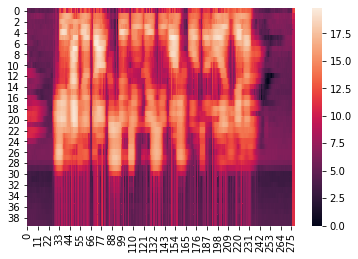

In [218]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/datasets/SAVEE/JK_sa01.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
feature = np.vstack((heatmap_data, (np.zeros((300-heatmap_data.shape[0],40,3),float))))
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(heatmap_data[:,:,0].T)

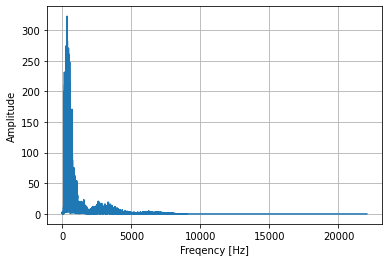

In [219]:
F = np.fft.fft(X) # 変換結果
N = X.shape[0]
freq = np.fft.fftfreq(N, d=1/44100) # 周波数
Amp = np.abs(F/(N/2)) # 振幅
fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()

In [190]:
with open("../2020_12_12_SERv3/extractMell.pkl","rb") as file:
    features, label = pickle.load(file)#3,119

male_sad
male_sad


<AxesSubplot:>

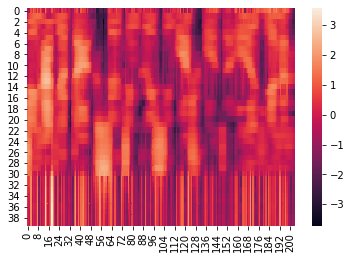

In [220]:
features[0].shape
print(inverselabel(label[0]))
preds = loaded_model.predict_step(np.expand_dims(features[0],axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(features[0][48:252,:,0].T)